In [1]:
import torch
import torchmetrics
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
from matplotlib import pyplot as plt
from sklearn.model_selection import StratifiedGroupKFold
from torch.utils.data import DataLoader, Dataset, Subset

In [2]:
'''
currently available samples:
SQ1631_s1_R, SQ1631_s2_R, SQ1631_s3_N, SQ1631_s4_N
SQ1632_s1_R, SQ1632_s2_N, SQ1632_s3_R, SQ1632_s4_N
SQ1633_s1_R, SQ1633_s2_R, SQ1633_s3_N, SQ1633_s4_N
'''
sample_ls = ['SQ1631_s1_R', 'SQ1631_s2_R', 'SQ1631_s3_N', 'SQ1631_s4_N',
             'SQ1632_s1_R', 'SQ1632_s2_N', 'SQ1632_s3_R', 'SQ1632_s4_N',
             'SQ1633_s1_R', 'SQ1633_s2_R', 'SQ1633_s3_N', 'SQ1633_s4_N']


In [3]:
# get all channel means
channel_names = []
channel_means = []
for sample_name in sample_ls:
    slide = np.load(f'../data/npy/{sample_name}.npy', mmap_mode='r')
    mask = np.sum(slide, axis=0) > 0
    nonzero = slide[:, mask]
    channel_mean = np.mean(nonzero, axis=1)
    channels = pd.read_csv(f'../data/npy/{sample_name}_channel_names.csv', header=None, index_col=0)
    channels = [name[0] for name in channels.to_numpy()]
    channels = [mz.split('-±')[0] for mz in channels]
    channel_means.append(pd.DataFrame(channel_mean, index=channels, columns=[sample_name]))
    channel_names.append(channels)
channel_means = pd.concat(channel_means, axis=1)

In [4]:
# check if all channels are in the same order
def all_arrays_identical(array_list):
    if not array_list:
        return True  # An empty list is considered to have all identical elements
    first_array = array_list[0]
    return all(np.array_equal(first_array, arr) for arr in array_list)

all_arrays_identical(channel_names)

True

In [5]:
channel_means.head()

,SQ1631_s1_R,SQ1631_s2_R,SQ1631_s3_N,SQ1631_s4_N,SQ1632_s1_R,SQ1632_s2_N,SQ1632_s3_R,SQ1632_s4_N,SQ1633_s1_R,SQ1633_s2_R,SQ1633_s3_N,SQ1633_s4_N
1000.565-mz,88.944872,134.584369,137.769541,135.367041,147.100422,111.933485,91.905511,118.107296,123.413053,155.671154,104.339001,150.898509
1000.873-mz,93.053695,59.404343,52.883811,160.652927,128.505828,21.209495,92.511706,143.841034,22.334094,149.163340,65.656847,153.911910
1001.561-mz,104.595074,141.783420,136.093482,128.771291,142.112749,104.986916,86.739465,116.537828,117.122204,151.178731,106.887063,136.069365
1002.586-mz,127.088362,121.138831,120.281246,116.492221,112.996349,97.353964,66.035538,75.497733,121.001369,132.512144,87.112461,123.639564
1003.584-mz,110.424475,116.552839,112.678809,114.199439,114.947377,94.802335,65.774403,91.063149,97.008786,122.804395,92.814209,114.448208


/gpfs/data/proteomics/home/liuw09/conda/envs/pt2/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/gpfs/data/proteomics/home/liuw09/conda/envs/pt2/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


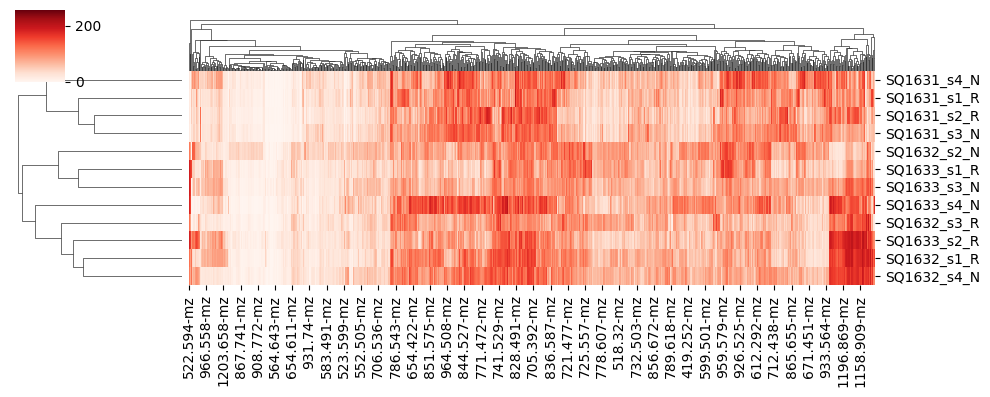

In [6]:
sns.clustermap(channel_means.T, cmap="Reds", vmin=0, vmax=255, figsize=(10, 4))
plt.show()

In [ ]:
# try random forest classifier on channel_means data
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier

In [40]:
labels = [name[-1] for name in channel_means.columns]
print(labels)
response = [1 if lab == 'R' else 0 for lab in labels]
print(response)

X = channel_means.T.to_numpy()
y = np.asarray(response)

# Create a RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=0)

# Create a KFold object with 4 splits
kf = KFold(n_splits=4, shuffle=True, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(rf, X, y, cv=kf)

# Print the cross-validation scores
print("Cross-validation scores for each fold: ", cv_scores)
print("Mean cross-validation score: ", np.mean(cv_scores))

['R', 'R', 'N', 'N', 'R', 'N', 'R', 'N', 'R', 'R', 'N', 'N']
[1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0]
Cross-validation scores for each fold:  [0.33333333 0.66666667 0.66666667 0.66666667]
Mean cross-validation score:  0.5833333333333333


In [39]:
# Initialize lists to store predictions and true labels
all_predictions = []
all_true_labels = []

# Perform manual cross-validation

for train_index, test_index in kf.split(X):
    # Split the data into training and validation sets
    print(train_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Fit the model on the training set
    rf.fit(X_train, y_train)
    
    # Predict on the validation set
    y_pred = rf.predict(X_test)
    
    # Store predictions and true labels
    all_predictions.append(y_pred)
    all_true_labels.append(y_test)
    
    # Print predictions and true labels for the current fold
    print(f"Predictions for fold: {y_pred}")
    print(f"True labels for fold: {y_test}")
    print("----------")

# Convert the lists of arrays to a single array
all_predictions = np.concatenate(all_predictions)
all_true_labels = np.concatenate(all_true_labels)

# Print overall predictions and true labels
print("All predictions:", all_predictions)
print("All true labels:", all_true_labels)

[ 1  2  3  4  5  6  7  8 11]
Predictions for fold: [0 1 0]
True labels for fold: [1 1 0]
----------
[ 0  1  3  4  6  7  9 10 11]
Predictions for fold: [1 0 1]
True labels for fold: [0 0 1]
----------
[ 0  2  3  5  6  7  8  9 10]
Predictions for fold: [0 1 0]
True labels for fold: [1 1 0]
----------
[ 0  1  2  4  5  8  9 10 11]
Predictions for fold: [0 0 0]
True labels for fold: [0 1 0]
----------
All predictions: [0 1 0 1 0 1 0 1 0 0 0 0]
All true labels: [1 1 0 0 0 1 1 1 0 0 1 0]


In [6]:
# inspect individual samples
sample_name = sample_ls[0]
slide = np.load(f'../data/npy/{sample_name}.npy', mmap_mode='r')
channels = pd.read_csv(f'../data/npy/{sample_name}_channel_names.csv', header=None, index_col=0)
channels = [name[0] for name in channels.to_numpy()]
print(channels[0:10])
channels = [mz.split('-±')[0] for mz in channels]
print(channels[0:10])

['1000.565-mz-±-25-mDa-1K0-1.56-±-0.05', '1000.873-mz-±-25-mDa-1K0-1.3-±-0.05', '1001.561-mz-±-25-mDa-1K0-1.56-±-0.05', '1002.586-mz-±-25.1-mDa-1K0-1.57-±-0.05', '1003.584-mz-±-25.1-mDa-1K0-1.57-±-0.05', '1004.886-mz-±-25.1-mDa-1K0-1.34-±-0.05', '1005.754-mz-±-25.1-mDa-1K0-1.61-±-0.05', '1006.757-mz-±-25.2-mDa-1K0-1.61-±-0.05', '1007.756-mz-±-25.2-mDa-1K0-1.61-±-0.05', '1008.586-mz-±-25.2-mDa-1K0-1.57-±-0.05']
['1000.565-mz', '1000.873-mz', '1001.561-mz', '1002.586-mz', '1003.584-mz', '1004.886-mz', '1005.754-mz', '1006.757-mz', '1007.756-mz', '1008.586-mz']


In [7]:
print(slide.shape)
mask = np.sum(slide, axis=0) > 0

(917, 500, 500)


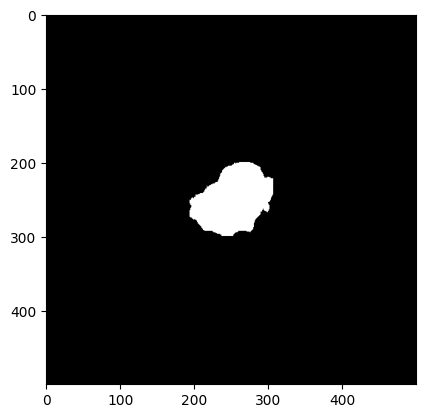

In [8]:
plt.imshow(mask, cmap='gray')

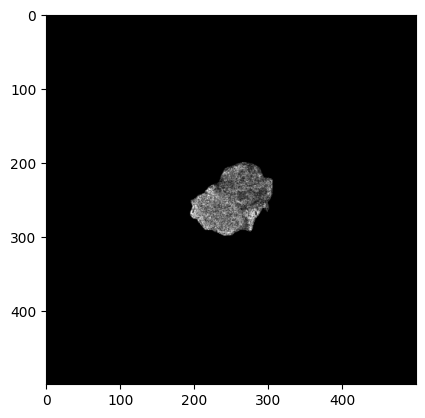

In [33]:
plt.imshow(slide[750, ], cmap='gray')

In [9]:
# channel wise correlation
nonzero = slide[:, mask]
print(f'None zero pixels: {nonzero.shape}')
corr = np.corrcoef(nonzero)

None zero pixels: (917, 7673)


/gpfs/data/proteomics/home/liuw09/conda/envs/pt2/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/gpfs/data/proteomics/home/liuw09/conda/envs/pt2/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


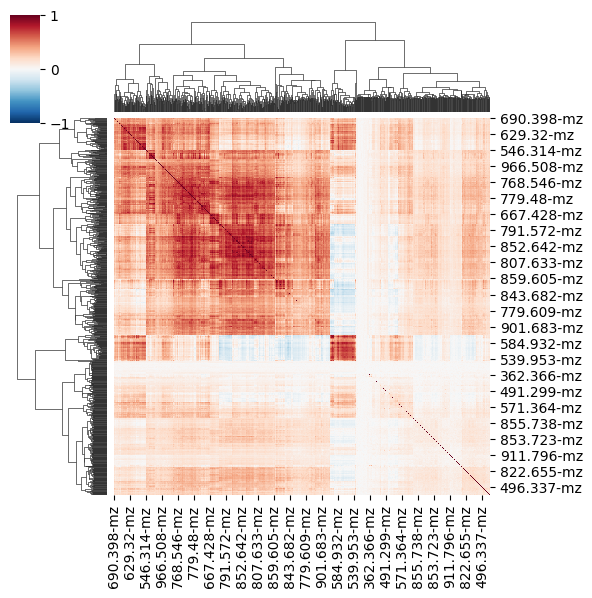

In [10]:
sns.clustermap(pd.DataFrame(corr, index=channels, columns=channels), cmap="RdBu_r", vmin=-1, vmax=1, figsize=(6, 6))
plt.show()
#plt.imshow(corr, cmap='RdBu')

In [4]:
# create tiles
def tile_array(array, tile_size, overlap, threshold):
    c, h, w = array.shape
    step_size = tile_size - overlap
    nx = w // step_size + 1
    ny = h // step_size + 1
    mask = np.sum(array, axis=0) > 0
    tiles = []
    coords = []
    for i in range(nx):
        for j in range(ny):
            
            x = i * step_size
            y = j * step_size
            x_end = min((x + tile_size), w)
            y_end = min((y + tile_size), h)
            if np.mean(mask[y :y_end, x : x_end]) > threshold:
                tile = np.zeros((c, tile_size, tile_size))
                tile[:,: y_end-y, :x_end-x] = array[:, y :y_end, x : x_end]
                tiles.append(tile)
                coords.append([x, y])
            else:
                pass
    return tiles, coords

class TileDataset(Dataset):
    def __init__(self, inputs, labels):
        self.inputs = inputs
        self.labels = labels
        from torchvision.transforms import v2
        self.transform = v2.Compose([
                                        #v2.ToImage(),
                                        v2.ToDtype(torch.float, scale=True),
                                        #v2.Lambda(lambda x: (x - 0.5)*2)
                                        ])
    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, index):
        #x = np.expand_dims(self.inputs[index], 0)
        x = torch.Tensor(self.inputs[index])
        x = self.transform(x)
        #print(x.shape)
        y = torch.tensor(self.labels[index], dtype=torch.float)
        return x, y

    
class SimpleCNN(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.conv = nn.Sequential(nn.Conv2d(in_channels, 16, 1),
                                   nn.ReLU(),
                                   nn.Conv2d(16, 8, 3, stride=2),
                                   nn.ReLU(),
                                   nn.Conv2d(8, 8, 3, stride=2),
                                   nn.ReLU(),
                                   nn.Conv2d(8, 8, 3, stride=2),
                                   nn.ReLU()
                                  )
        self.fc = nn.Linear(8, 1)

    def forward(self, x):
        x = self.conv(x)
        #print(x.shape)
        x = torch.mean(x, dim = (2, 3), keepdim = False) # Global pooling
        #print(x.shape)
        out = self.fc(x)
        out = torch.squeeze(out)
        if out.ndim == 0:
            out = out.unsqueeze(0)
        return out
    
def train_and_evaluate(n_epochs, model, trn_loader, tst_loader):
    criterion = nn.BCEWithLogitsLoss()
    accuracy_fun = torchmetrics.Accuracy(task='binary')
    roc_fun = torchmetrics.AUROC(task='binary')
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    for epoch in range(n_epochs):
        print('EPOCH {}:'.format(epoch + 1))
        model.train()
        running_loss = 0.
        for i, (inputs, labels) in enumerate(trn_loader):
            optimizer.zero_grad()
            logits = model(inputs)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i % 10 == 9:  # Print every 100 batches
                print(f'Epoch [{epoch + 1}/{n_epochs}], Step [{i + 1}/{len(trn_loader)}], Loss: {running_loss / 100:.4f}')
                running_loss = 0.0
    print('Finished Training')

    # test model and report metric
    model.eval()
    running_loss = 0.
    all_probs = []
    all_labels = []
    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(tst_loader):
            logits = model(inputs)
            all_labels.append(labels)
            all_probs.append(nn.Sigmoid()(logits).cpu())
            loss = criterion(logits, labels)
            running_loss += loss
    all_probs = torch.cat(all_probs)
    print(all_probs)
    all_labels = torch.cat(all_labels)
    print(all_labels)
    avg_loss = running_loss / (i + 1)
    accuracy = accuracy_fun(all_probs, all_labels)
    auc = roc_fun(all_probs, all_labels)
    print(f'Test loss: {avg_loss}; AUROC: {auc}; Accuracy: {accuracy}')
    return accuracy, auc
    

In [5]:
tile_ls = []
label_ls = []
tile_grp = []
tile_coords = []

for sample_name in sample_ls[0:4]:
    slide = np.load(f'../data/npy/{sample_name}.npy', mmap_mode='r')
    tiles, coords = tile_array(slide, tile_size=32, overlap=8, threshold=0.2)
    labels = [1 if sample_name[-1] == 'R' else 0] * len(tiles)
    print(f'{len(tiles)} tiles generated in sample {sample_name}.')
    tile_ls.extend(tiles)
    label_ls.extend(labels)
    tile_grp.extend([sample_name] * len(tiles))
    tile_coords.extend(coords)

tile_ls = np.asarray(tile_ls)
label_ls = np.asarray(label_ls)
print(tile_ls.shape)
print(label_ls.shape)

18 tiles generated in sample SQ1631_s1_R.
84 tiles generated in sample SQ1631_s2_R.
65 tiles generated in sample SQ1631_s3_N.
30 tiles generated in sample SQ1631_s4_N.
(197, 917, 32, 32)
(197,)


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_epochs = 10 
print(tile_ls[0].shape)
tile_dat = TileDataset(inputs=tile_ls, labels=label_ls)
print(len(tile_dat))

def collate_fn(batch):
    inputs, labels = zip(*batch)
    #print(inputs[0].shape)
    inputs = torch.stack(inputs, 0)
    labels = torch.stack(labels)
    #print(inputs.shape)
    #print(labels)
    inputs = inputs.to(device)
    labels = labels.to(device)
    return inputs, labels
        
sgkf = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=42)

for i, (trn_idx, tst_idx) in enumerate(sgkf.split(X=np.zeros(len(label_ls)), y=label_ls, groups=tile_grp)):
    print(f'Fold {i}')
    print('--------------------------------')
    trn_subset = Subset(tile_dat, trn_idx)
    tst_subset = Subset(tile_dat, tst_idx)
    print(trn_idx)
    print(tst_idx)
    # Define data loaders for training and testing data in this fold
    trn_loader = DataLoader(trn_subset, batch_size=4, shuffle=True, collate_fn=collate_fn)
    tst_loader = DataLoader(tst_subset, batch_size=4, shuffle=False, collate_fn=collate_fn)

    # Initialize the model for this fold
    model = SimpleCNN(in_channels=917).to(device)
    auc, accuracy = train_and_evaluate(n_epochs, model, trn_loader, tst_loader)

(917, 32, 32)
197
Fold 0
--------------------------------
[ 18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
EPOCH 1:
Epoch [1/10], Step [10/45], Loss: 0.0745
Epoch [1/10], Step [20/45], Loss: 0.0690
Epoch [1/10], Step [30/45], Loss: 0.0678
Epoch [1/10], Step [40/45],

/gpfs/data/proteomics/home/liuw09/conda/envs/pt2/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch [1/10], Step [20/42], Loss: 0.0609
Epoch [1/10], Step [30/42], Loss: 0.0649
Epoch [1/10], Step [40/42], Loss: 0.0636
EPOCH 2:
Epoch [2/10], Step [10/42], Loss: 0.0356
Epoch [2/10], Step [20/42], Loss: 0.0223
Epoch [2/10], Step [30/42], Loss: 0.0933
Epoch [2/10], Step [40/42], Loss: 0.0514
EPOCH 3:
Epoch [3/10], Step [10/42], Loss: 0.0431
Epoch [3/10], Step [20/42], Loss: 0.0181
Epoch [3/10], Step [30/42], Loss: 0.0142
Epoch [3/10], Step [40/42], Loss: 0.0089
EPOCH 4:
Epoch [4/10], Step [10/42], Loss: 0.0047
Epoch [4/10], Step [20/42], Loss: 0.0056
Epoch [4/10], Step [30/42], Loss: 0.0335
Epoch [4/10], Step [40/42], Loss: 0.0320
EPOCH 5:
Epoch [5/10], Step [10/42], Loss: 0.0042
Epoch [5/10], Step [20/42], Loss: 0.0113
Epoch [5/10], Step [30/42], Loss: 0.0064
Epoch [5/10], Step [40/42], Loss: 0.0048
EPOCH 6:
Epoch [6/10], Step [10/42], Loss: 0.0033
Epoch [6/10], Step [20/42], Loss: 0.0012
Epoch [6/10], Step [30/42], Loss: 0.0004
Epoch [6/10], Step [40/42], Loss: 0.0006
EPOCH 7:
Epo

/gpfs/data/proteomics/home/liuw09/conda/envs/pt2/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch [1/10], Step [10/29], Loss: 0.0501
Epoch [1/10], Step [20/29], Loss: 0.0463
EPOCH 2:
Epoch [2/10], Step [10/29], Loss: 0.0293
Epoch [2/10], Step [20/29], Loss: 0.0193
EPOCH 3:
Epoch [3/10], Step [10/29], Loss: 0.0355
Epoch [3/10], Step [20/29], Loss: 0.0255
EPOCH 4:
Epoch [4/10], Step [10/29], Loss: 0.0080
Epoch [4/10], Step [20/29], Loss: 0.0125
EPOCH 5:
Epoch [5/10], Step [10/29], Loss: 0.0163
Epoch [5/10], Step [20/29], Loss: 0.0058
EPOCH 6:
Epoch [6/10], Step [10/29], Loss: 0.0088
Epoch [6/10], Step [20/29], Loss: 0.0123
EPOCH 7:
Epoch [7/10], Step [10/29], Loss: 0.0090
Epoch [7/10], Step [20/29], Loss: 0.0036
EPOCH 8:
Epoch [8/10], Step [10/29], Loss: 0.0000
Epoch [8/10], Step [20/29], Loss: 0.0001
EPOCH 9:
Epoch [9/10], Step [10/29], Loss: 0.0589
Epoch [9/10], Step [20/29], Loss: 0.7682
EPOCH 10:
Epoch [10/10], Step [10/29], Loss: 0.0083
Epoch [10/10], Step [20/29], Loss: 0.0072
Finished Training
tensor([1.2715e-04, 5.4087e-05, 1.7819e-01, 3.3762e-05, 2.1230e-06, 2.6494e-05

In [15]:
np.asarray(tile_grp)[tst_idx]

array(['SQ1631_s3_N', 'SQ1631_s3_N', 'SQ1631_s3_N', 'SQ1631_s3_N',
       'SQ1631_s3_N', 'SQ1631_s3_N', 'SQ1631_s3_N', 'SQ1631_s3_N',
       'SQ1631_s3_N', 'SQ1631_s3_N', 'SQ1631_s3_N', 'SQ1631_s3_N',
       'SQ1631_s3_N', 'SQ1631_s3_N', 'SQ1631_s3_N', 'SQ1631_s3_N',
       'SQ1631_s3_N', 'SQ1631_s3_N', 'SQ1631_s3_N', 'SQ1631_s3_N',
       'SQ1631_s3_N', 'SQ1631_s3_N', 'SQ1631_s3_N', 'SQ1631_s3_N',
       'SQ1631_s3_N', 'SQ1631_s3_N', 'SQ1631_s3_N', 'SQ1631_s3_N',
       'SQ1631_s3_N', 'SQ1631_s3_N', 'SQ1631_s3_N', 'SQ1631_s3_N',
       'SQ1631_s3_N', 'SQ1631_s3_N', 'SQ1631_s3_N', 'SQ1631_s3_N',
       'SQ1631_s3_N', 'SQ1631_s3_N', 'SQ1631_s3_N', 'SQ1631_s3_N',
       'SQ1631_s3_N', 'SQ1631_s3_N', 'SQ1631_s3_N', 'SQ1631_s3_N',
       'SQ1631_s3_N', 'SQ1631_s3_N', 'SQ1631_s3_N', 'SQ1631_s3_N',
       'SQ1631_s3_N', 'SQ1631_s3_N', 'SQ1631_s3_N', 'SQ1631_s3_N',
       'SQ1631_s3_N', 'SQ1631_s3_N', 'SQ1631_s3_N', 'SQ1631_s3_N',
       'SQ1631_s3_N', 'SQ1631_s3_N', 'SQ1631_s3_N', 'SQ1631_s3

In [1]:
plt.imshow(tile_ls[0][750,:,:], cmap='gray')

NameError: name 'plt' is not defined

['R', 'R', 'R', 'R', 'R']